In [1]:
import os
import sys
def getRepoPath():
    cwd = os.getcwd()
    delimiter = "\\" if "\\" in cwd else "/"
    repoPath = delimiter.join(cwd.split(delimiter)[:cwd.split(delimiter).index("dataImport")]) + delimiter
    return repoPath
repoPath = getRepoPath()
sys.path.append(repoPath + 'dataImport/')
from utils import workingDataPath, getWorkingHRDfParquet, getHRGroups, calcIntersectionOfMultipleGroups, getHRsForTimePeriods, secBySecHRGraph
import pandas as pd
from datetime import date, time, timedelta

/home/chowder/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
appleHRDf = getWorkingHRDfParquet('apple')
polarHRDf = getWorkingHRDfParquet('polar')
fitbitHRDf = getWorkingHRDfParquet('fitbit')
appleGroups = getHRGroups(appleHRDf, 20)
polarGroups = getHRGroups(polarHRDf, 20)
fitbitGroups = getHRGroups(fitbitHRDf, 20)
all_intersections = calcIntersectionOfMultipleGroups([appleGroups, fitbitGroups, polarGroups])
all_intersections_lengths = [g[1] - g[0] for g in all_intersections]
maxLenIntersectIndex = all_intersections_lengths.index(max(all_intersections_lengths))

In [4]:
groupI = maxLenIntersectIndex
groups = all_intersections
polarSecDf = getHRsForTimePeriods(pd.DataFrame([groups[groupI]], columns = ['startDate', 'endDate']), polarHRDf)
fitbitSecDf = getHRsForTimePeriods(pd.DataFrame([groups[groupI]], columns = ['startDate', 'endDate']), fitbitHRDf)
appleSecDf = getHRsForTimePeriods(pd.DataFrame([groups[groupI]], columns = ['startDate', 'endDate']), appleHRDf)

In [51]:
interpType = 'cubic'
polarSecDfInterp = polarSecDf.resample('1s').asfreq().interpolate(method=interpType).round()
fitbitSecDfInterp = fitbitSecDf.resample('1s').asfreq().interpolate(method=interpType).round()
appleSecDfInterp = appleSecDf.resample('1s').asfreq().interpolate(method=interpType).round()

In [52]:
polarSecDfInterp

,value
sampleDT,
2024-09-17 01:29:36-07:00,78.0
2024-09-17 01:29:37-07:00,79.0
2024-09-17 01:29:38-07:00,79.0
2024-09-17 01:29:39-07:00,78.0
2024-09-17 01:29:40-07:00,77.0
...,...
2024-09-17 10:11:22-07:00,68.0
2024-09-17 10:11:23-07:00,69.0
2024-09-17 10:11:24-07:00,70.0


In [54]:
fitbitSecDfInterp = fitbitSecDfInterp.loc[polarSecDf.index.intersection(fitbitSecDfInterp.index)]
polarSecDfInterp = polarSecDfInterp.loc[polarSecDf.index.intersection(fitbitSecDfInterp.index)]
appleSecDfInterp = appleSecDfInterp.loc[polarSecDf.index.intersection(appleSecDfInterp.index)]

In [61]:
# for these
# I'll make the dynamics model the velocity of the polar data
def kalmanFilterVPolarPlus(polarDf, otherDf):
    kalmanGain = .1
    initialEstimate = polarDf.value.iloc[0]
    currentEstimate = initialEstimate

    estimates = []
    for i in range(1,len(polarDf)-1):
        estimates.append(currentEstimate)
        lastEstimate = currentEstimate

        #dynamics Function
        predictedEstimate = lastEstimate + (polarDf.value.iloc[i] - polarDf.value.iloc[i-1])

        measurement = otherDf.value.iloc[i]

        measurementResidual = (measurement - predictedEstimate)
        currentEstimate = predictedEstimate + (kalmanGain * measurementResidual)
    
    estimates.append(currentEstimate)

    return pd.DataFrame(index=polarDf.index[:-1], data=estimates, columns=['value']).round()


In [62]:
kalmanValsPFV = kalmanFilterVPolarPlus(polarSecDfInterp, fitbitSecDfInterp)

In [64]:
kalmanValsPAV = kalmanFilterVPolarPlus(polarSecDfInterp, appleSecDfInterp)

In [63]:
kalmanValsPF

,value
sampleDT,
2024-09-17 01:29:38-07:00,79.0
2024-09-17 01:29:39-07:00,78.0
2024-09-17 01:29:40-07:00,76.0
2024-09-17 01:29:41-07:00,74.0
2024-09-17 01:29:42-07:00,73.0
...,...
2024-09-17 10:11:17-07:00,63.0
2024-09-17 10:11:18-07:00,64.0
2024-09-17 10:11:19-07:00,64.0


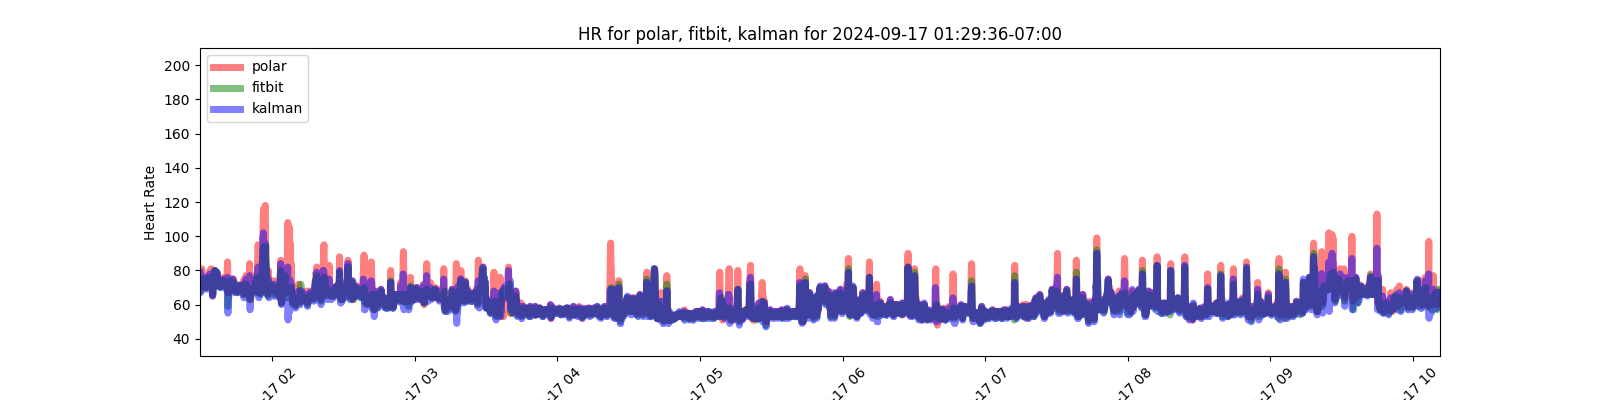

In [65]:
%matplotlib widget

secBySecHRGraph([polarSecDfInterp, fitbitSecDfInterp, kalmanValsPF], groups[groupI], ['polar', 'fitbit', 'kalman'], False)

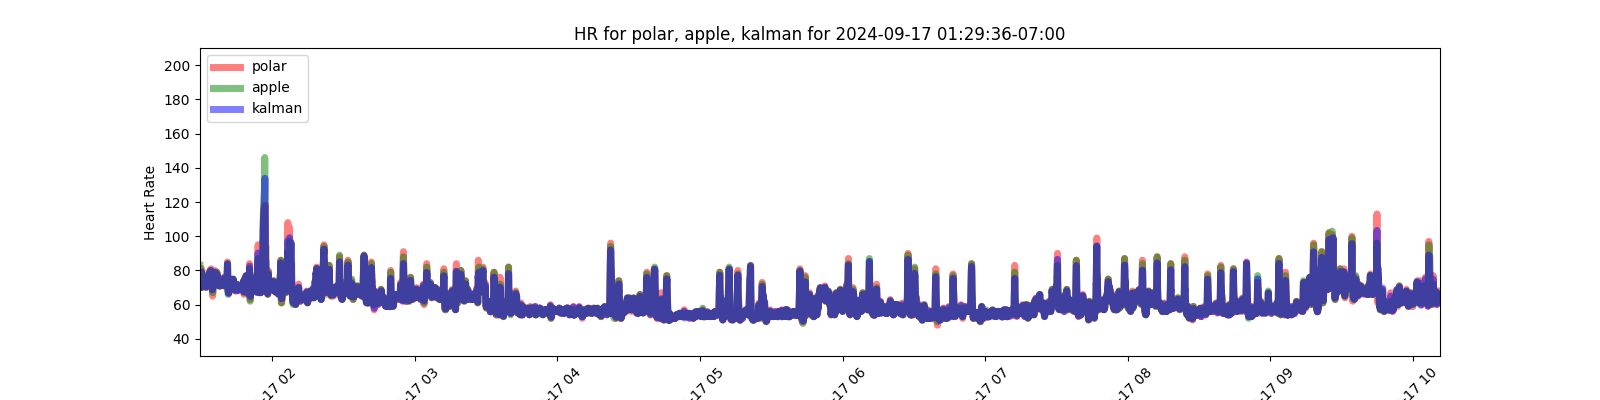

In [60]:
secBySecHRGraph([polarSecDfInterp, appleSecDfInterp, kalmanValsPA], groups[groupI], ['polar', 'apple', 'kalman'], False)

In [68]:
def kalmanFilterPPolarPlus(polarDf, otherDf):
    kalmanGain = .1
    initialEstimate = polarDf.value.iloc[0]
    currentEstimate = initialEstimate

    estimates = []
    for i in range(1,len(polarDf)-1):
        estimates.append(currentEstimate)
        lastEstimate = currentEstimate

        #dynamics Function
        predictedEstimate = polarDf.value.iloc[i]

        measurement = otherDf.value.iloc[i]

        measurementResidual = (measurement - predictedEstimate)
        currentEstimate = predictedEstimate + (kalmanGain * measurementResidual)
    
    estimates.append(currentEstimate)

    return pd.DataFrame(index=polarDf.index[:-1], data=estimates, columns=['value']).round()

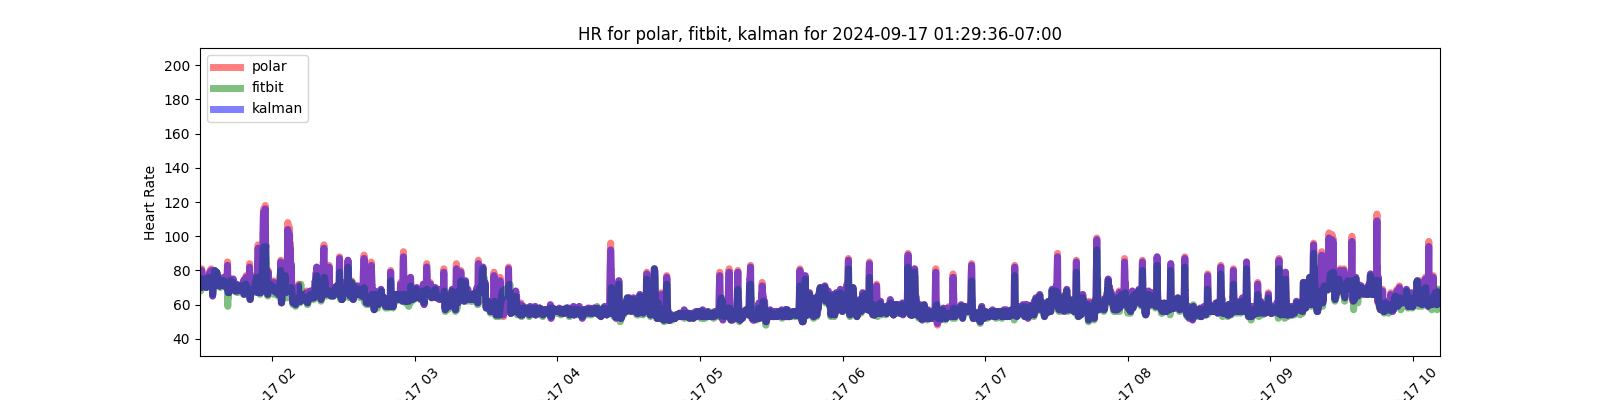

In [69]:
kalmanValsPFP = kalmanFilterPPolarPlus(polarSecDfInterp, fitbitSecDfInterp)
secBySecHRGraph([polarSecDfInterp, fitbitSecDfInterp, kalmanValsPFP], groups[groupI], ['polar', 'fitbit', 'kalman'], False)

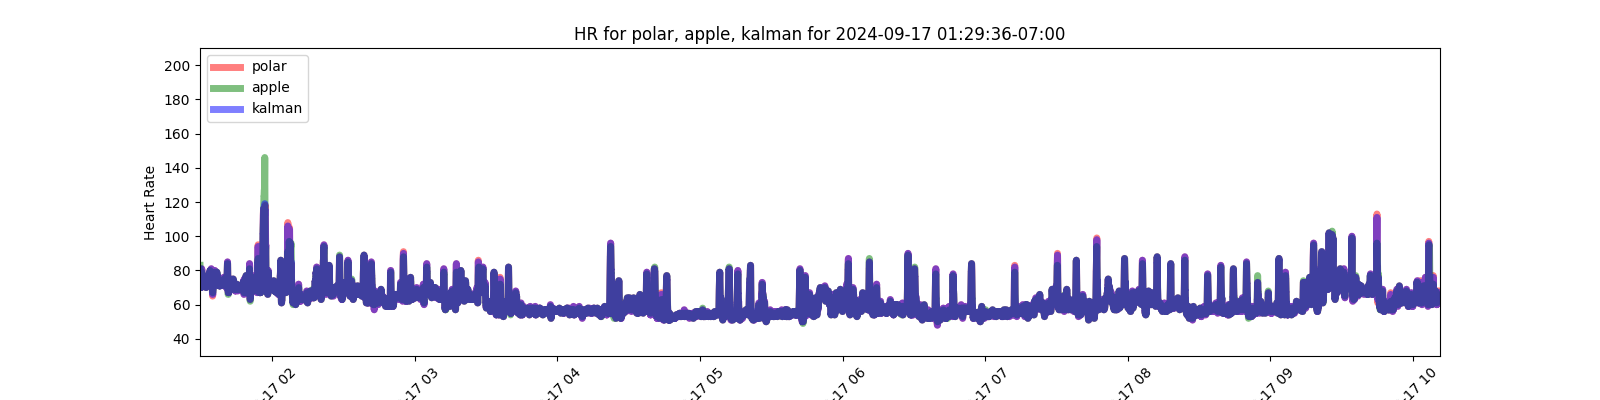

In [70]:
kalmanValsPAP = kalmanFilterPPolarPlus(polarSecDfInterp, appleSecDfInterp)
secBySecHRGraph([polarSecDfInterp, appleSecDfInterp, kalmanValsPAP], groups[groupI], ['polar', 'apple', 'kalman'], False)